In [1]:
# import the packages
import numpy as np
from scipy.fftpack import dct
from scipy.io import loadmat
from numpy.linalg import lstsq
from sklearn.linear_model import Lasso

In [2]:
def DFT321f(accXYZ_input):
    """
    Python/Numpy version of the MATLAB DFT321f function.
    
    Parameters
    ----------
    u : ndarray, shape (N_sampl, 3)
        Each column stores acceleration data of x, y, and z axes.
    
    Returns
    -------
    y : ndarray, shape (N_sampl,)
        Reconstructed time-domain signal using the DFT321 approach.
    """
    accXYZ_input = np.asarray(accXYZ_input)
    num_samples, num_channels = accXYZ_input.shape

    # Check whether the signal length is even or odd
    odd_num_samples = num_samples % 2

    # FFT of each channel
    accXYZ_input_fft = np.fft.fft(accXYZ_input, axis=0)

    # Place of the Nyquist component depends on odd/even length
    if odd_num_samples:
        num_samples_half = (num_samples + 1) // 2
    else:
        num_samples_half = num_samples // 2 + 1

    # Magnitude of combined spectrum
    acc_combined_fft_mag = np.real(np.sqrt(np.sum(accXYZ_input_fft[:num_samples_half, :] * np.conj(accXYZ_input_fft[:num_samples_half, :]), axis=1)))

    # Phase: sum of complex vectors across channels
    acc_combined_fft_phase = np.angle(np.sum(accXYZ_input_fft[:num_samples_half, :], axis=1))

    # Integrated spectrum
    acc_combined_fft = acc_combined_fft_mag * np.exp(1j * acc_combined_fft_phase)

    # Mirror to get full spectrum
    if odd_num_samples:
        acc_combined_fft = np.concatenate([acc_combined_fft, np.conj(acc_combined_fft[-2:0:-1])])
    else:
        acc_combined_fft = np.concatenate([acc_combined_fft, np.conj(acc_combined_fft[-2:0:-1])])

    # Reconstruct time-domain signal
    acc_combined = np.real(np.fft.ifft(acc_combined_fft))

    return acc_combined

In [3]:
# -----------------------------------------------------------
# Step 1: Preprocessing (normalize to [-1,1])
# -----------------------------------------------------------
def normalize_signal(x):
    xmax = np.max(x[x > 0]) if np.any(x > 0) else 1
    xmin = np.min(x[x < 0]) if np.any(x < 0) else -1
    x_norm = np.zeros_like(x, dtype=float)

    x_norm[x > 0] = x[x > 0] / xmax
    x_norm[x < 0] = x[x < 0] / abs(xmin)
    return x_norm

In [4]:
# -----------------------------------------------------------
# Step 2: Sparse Linear Prediction (simplified AR coeffs)
# -----------------------------------------------------------
def slp_coefficients(x, K=20, gamma_range=np.linspace(0.01, 1.5, 30)):
    """
    Sparse Linear Prediction with optimal gamma selection (Annex F.1.2).
    
    Args:
        x : 1D numpy array (input vibrotactile frame)
        K : int, prediction order
        gamma_range : array-like, values of gamma to try
    
    Returns:
        a_opt : numpy array, optimal SLP coefficients
        gamma_opt : float, selected gamma value
        coeff_norms : list of ||a||_1 values for each gamma
        residual_norms : list of ||x - Xa||_1 values for each gamma
    """
    N = len(x)
    # Construct regression matrix
    X = np.zeros((N-K, K))
    for i in range(K, N):
        X[i-K] = x[i-K:i][::-1]
    y = x[K:]

    residual_norms = []
    coeff_norms = []
    solutions = []

    # Sweep gamma values
    for gamma in gamma_range:
        model = Lasso(alpha=gamma, fit_intercept=False, max_iter=5000)
        model.fit(X, y)
        a = model.coef_
        r = y - X @ a
        residual_norms.append(np.linalg.norm(r, 1))
        coeff_norms.append(np.linalg.norm(a, 1))
        solutions.append(a)

    residual_norms = np.array(residual_norms)
    coeff_norms = np.array(coeff_norms)

    # Find "corner" of the L-curve (max distance to line between endpoints)
    x1, y1 = coeff_norms[0], residual_norms[0]
    x2, y2 = coeff_norms[-1], residual_norms[-1]
    distances = []
    for xi, yi in zip(coeff_norms, residual_norms):
        num = abs((y2-y1)*xi - (x2-x1)*yi + x2*y1 - y2*x1)
        den = np.sqrt((y2-y1)**2 + (x2-x1)**2)
        distances.append(num/den)
    best_idx = int(np.argmax(distances))

    gamma_opt = gamma_range[best_idx]
    a_opt = solutions[best_idx]

    residual_norms = y - X @ a_opt

    return a_opt, residual_norms
    
    #return a_opt, gamma_opt, coeff_norms, residual_norms

In [5]:
# -----------------------------------------------------------
# Step 3: SLP to RC (Levinson recursion simplified)
# -----------------------------------------------------------
def slp_to_rc(a):
    N = len(a)
    rc = np.zeros(N)
    a_curr = a.copy()
    for n in range(N, 0, -1):
        rc[n-1] = -a_curr[-1]
        if n > 1:
            a_prev = a_curr[:-1]
            a_curr = (a_prev + rc[n-1] * a_prev[::-1]) / (1 - rc[n-1]**2)
    return rc

In [6]:
# -----------------------------------------------------------
# Step 4: RC Quantization
# -----------------------------------------------------------
def quantize_rc(rc, delta=0.03):
    rc_q = np.round(rc / delta)
    rc_deq = rc_q * delta
    return rc_q, rc_deq

In [7]:
# -----------------------------------------------------------
# Step 5: RC to SLP Transformation (Levinson recursion)
# -----------------------------------------------------------
def rc_to_slp(rc):
    N = len(rc)
    slp = np.zeros((N, N))
    for m in range(N):
        slp[m, m] = 1
    a = np.zeros(N)
    for k in range(N):
        a[k] = rc[k]
        if k > 0:
            a[:k] += rc[k] * slp[k-1, :k][::-1]
        slp[k, :k+1] = a[:k+1]
    return a

In [8]:
# -----------------------------------------------------------
# Step 6: Residual Computation
# -----------------------------------------------------------
def compute_residual(x, a):
    K = len(a)
    N = len(x)
    r = np.zeros(N)
    for n in range(K, N):
        r[n] = x[n] + np.sum(a * x[n-K:n][::-1])
    return r

In [9]:
# -----------------------------------------------------------
# Step 7: Residual DCT + Perceptual Quantization
# -----------------------------------------------------------
def residual_dct_quant(r, asf, delta=0.1):
    R = dct(r, type=2, norm='ortho')
    eq = np.round(R / (delta * asf))
    eq_deq = eq * delta * asf
    return R, eq, eq_deq

In [10]:
# -----------------------------------------------------------
# Load Huffman dictionary from .mat file
# -----------------------------------------------------------
def load_huff_dict(mat_file, var_name):
    """Load Huffman dictionary from .mat file as a Python dict."""
    mat_data = loadmat(mat_file)
    entries = mat_data[var_name]   # cell array of shape (N, 2)
    
    huff_dict = {}
    for symbol, code in entries:
        sym = symbol.item()        # extract Python scalar
        huff_dict[sym] = str(code[0])  # extract string from MATLAB char array
    return huff_dict

In [11]:
def _detect_eob_symbol(huff_dict):
    """
    Heuristic: EOB often has a very short code (often length 1), or is a very large sentinel.
    1) Prefer any symbol with 1-bit code.
    2) Fallback to the largest integer symbol.
    """
    lengths = {s: len(c) for s, c in huff_dict.items()}
    one_bit = [s for s, L in lengths.items() if L == 1]
    if one_bit:
        return one_bit[0]
    # fallback: largest integer symbol
    ints = [s for s in huff_dict.keys() if isinstance(s, (int, np.integer))]
    return max(ints) if ints else None

In [12]:
# -----------------------------------------------------------
# Step 8: Zero Run Length Encoder
# -----------------------------------------------------------
def zrl_encode_flat(coeffs, dct_dict, eob_symbol=None):
    """
    Given a 1-D array/list of quantized DCT coeffs (ints), produce a FLAT sequence:
      - Nonzero v  -> emit v
      - Run of z 0s -> emit 0, z    (possibly split if z exceeds supported run values)
      - Append EOB at the end
    The run-lengths and nonzero values are both encoded as integers; context disambiguates them.
    """
    if eob_symbol is None:
        eob_symbol = _detect_eob_symbol(dct_dict)
        if eob_symbol is None:
            raise ValueError("Could not detect EOB symbol from the dictionary. Please pass eob_symbol explicitly.")

    # Allowed integer symbols we can emit for a run length (positive ints except 0 and EOB)
    allowed_runs = sorted(int(s) for s in dct_dict.keys()
                          if isinstance(s, (int, np.integer)) and s not in (0, eob_symbol) and s >= 1)

    out = []
    run = 0
    for v in coeffs:
        v = int(v)
        if v == 0:
            run += 1
            continue

        # flush any pending zeros as 0,chunk pairs
        if run > 0:
            while run > 0:
                # choose largest allowed chunk <= run (fallback 1 if needed)
                chunk = max([r for r in allowed_runs if r <= run] or [1])
                out.extend([0, chunk])
                run -= chunk

        # emit the non-zero coefficient as-is
        out.append(v)

    # tail zeros
    if run > 0:
        while run > 0:
            chunk = max([r for r in allowed_runs if r <= run] or [1])
            out.extend([0, chunk])
            run -= chunk

    # end-of-block
    out.append(eob_symbol)
    return out

In [13]:
# -----------------------------------------------------------
# Step 9: Huffman Encoder
# -----------------------------------------------------------
def huffman_encode(sequence, huff_dict):
    """
    Encode a sequence of symbols using a Huffman dictionary.
    sequence: iterable of symbols
    huff_dict: {symbol: code}
    Returns a string of concatenated Huffman bits.
    """
    encoded_bits = ""
    for symbol in sequence:
        if symbol not in huff_dict:
            raise ValueError(f"Symbol {symbol} not in Huffman dictionary")
        encoded_bits += huff_dict[symbol]
    return encoded_bits

In [14]:
def huffman_encode_sequence(symbols, huff_dict):
    """
    Encode a flat sequence of integers using the provided {symbol: bitstring} dict.
    Returns one concatenated bitstring.
    """
    missing = []
    bits = []
    for s in symbols:
        if s not in huff_dict:
            missing.append(s)
        else:
            bits.append(huff_dict[s])
    if missing:
        raise KeyError(f"Symbols not present in Huffman dict (first 10): {missing[:10]}")
    return ''.join(bits)

In [40]:
# -----------------------------------------------------------
# Example Run
# -----------------------------------------------------------
if __name__ == "__main__":

    tooltip = "1spike_Probe" # 1spike_Probe, 3x1spike_Probe
    material = "felt"  # cork, felt
    speed = "fast"  # medium, fast
    sampling_rate = 2800
    dct_quantization_scale = 1.0

    acc_samples_filename = "Direct_-_" + tooltip + "_-_" + material + "_-_" + speed + ".mat"

    rc_dict  = load_huff_dict("HuffmanDicRC.mat", "dict_RC")
    dct_dict = load_huff_dict("HuffmanDicDCT_QDCT_22.mat", "dict_DCT")

    material_samples = loadmat(acc_samples_filename)['material'][0][0]
    accX_samples = material_samples[1]
    accY_samples = material_samples[2]
    accZ_samples = material_samples[3]

    accXYZ_samples = np.column_stack((accX_samples, accY_samples, accZ_samples))

    acc_combined = DFT321f(accXYZ_samples)

    cut_point = int(material_samples[6].flatten()[0] - 1)

    acc_combined_cut = acc_combined[cut_point:cut_point + sampling_rate]

    acc_combined_cut_fft = np.abs(np.fft.fft(acc_combined_cut)[0:(sampling_rate // 2)])

    acc_combined_cut_fft = acc_combined_cut_fft / (sampling_rate / 2)

    acc_combined_cut_frame = acc_combined_cut[0:200]

    # Step 1: Normalize
    x_norm = normalize_signal(acc_combined_cut_frame)

    # Step 2: SLP coefficients
    a, r = slp_coefficients(x_norm, K=20)

    # Step 3: RC
    rc = slp_to_rc(a)

    # Step 4: Quantize RCs
    rc_q, rc_deq = quantize_rc(rc)

    # Step 5 (corrected): Convert dequantized RC back to SLP
    a_deq = rc_to_slp(rc_deq)

    # Step 6: Residual
    r = compute_residual(x_norm, a_deq)

    # Step 7: Residual DCT + Perceptual Quantization
    asf = np.ones_like(r)  # placeholder ASF = 1
    R, eq, eq_deq = residual_dct_quant(r, asf, dct_quantization_scale)

    # Step 8: Zero Run Length Encode residuals
    zrl_seq = zrl_encode_flat(eq, dct_dict)  # produces [v, 0, run, v, ..., EOB]

    # Step 9: Huffman Encode
    rc_bits  = huffman_encode(rc_q, rc_dict)
    res_bits = huffman_encode_sequence(zrl_seq, dct_dict)

    # Print key variables
    print("Normalized x:", x_norm[:10])
    print("SLP coeffs:", a[:5])
    print("RCs:", rc[:5])
    print("Quantized RCs:", rc_q[:5])
    print("Residual:", r[:10])
    print("DCT coeffs:", R[:10])
    print("Quantized DCT:", eq[:10])
    print("ZRL residuals:", zrl_res[:10])
    print("Huffman encoded RC bits:", rc_bits[:50], "...")
    print("Huffman encoded Residual bits:", res_bits[:50], "...")

KeyError: 'Symbols not present in Huffman dict (first 10): [-2]'

(1400,)


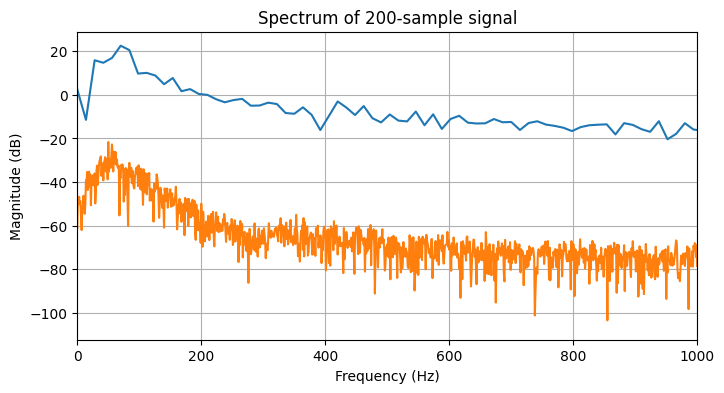

In [16]:
import matplotlib.pyplot as plt

X = np.fft.rfft(acc_combined_cut_frame)
freqs = np.fft.rfftfreq(200, 1/2800)

mag_db = 20 * np.log10(np.abs(X) + 1e-12)

R = np.fft.rfft(r)         # FFT
R_db = 20*np.log10(np.abs(R)+1e-12)

haha = 20 * np.log10(np.abs(acc_combined_cut_fft) + 1e-12)

print(haha.shape)

plt.figure(figsize=(8,4))
plt.plot(freqs, mag_db)
plt.plot(np.arange(1400), haha)
plt.xlim(0, 1000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Spectrum of 200-sample signal")
plt.grid(True)
plt.show()

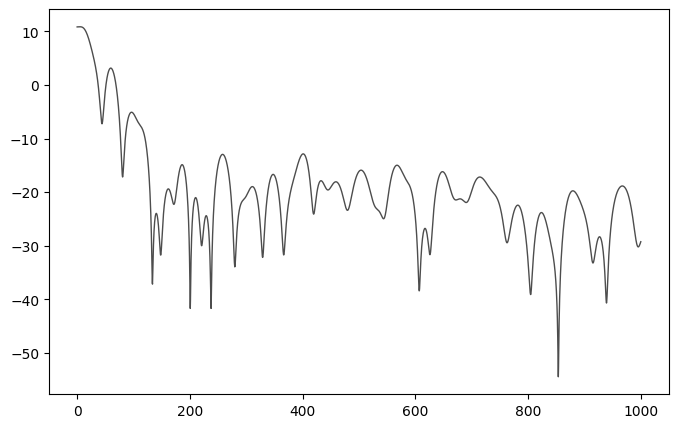

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, freqz, savgol_filter
from numpy.linalg import lstsq
from sklearn.linear_model import Lasso

nfft=8192
fs=2800
plot_up_to=1000

N = len(acc_combined_cut_frame)
win = get_window("hann", N)
xw = acc_combined_cut_frame * win
X = np.fft.rfft(xw, n=nfft)
freqs = np.fft.rfftfreq(nfft, 1/fs)
mag_fft_db = 20 * np.log10(np.abs(X) + 1e-12)

idx_lim = freqs <= plot_up_to

plt.figure(figsize=(8, 5))
plt.plot(freqs[idx_lim], mag_fft_db[idx_lim], color='0.3', linewidth=1, label='Raw FFT (hann, zero-padded)')